# Concise Implementation of Recurrent Neural Networks

## Reading the Dataset

Here, we will work with H. G. Wells’ The Time Machine, a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline. The following _download method reads the raw text into a string.



In [1]:
using Downloads

file_path = Downloads.download("http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt")

"/tmp/jl_u5uDyJi9IX"

In [2]:
raw_text = open(io->read(io, String),file_path)
raw_text[begin:60]

"The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra"

For simplicity, we ignore punctuation and capitalization when preprocessing the raw text.

In [3]:
str = lowercase(replace(raw_text,r"[^A-Za-z]+"=>" "))
str[begin:60]

"the time machine by h g wells i the time traveller for so it"

## Tokenization

Tokens are the atomic (indivisible) units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence “Baby needs a new pair of shoes” as a sequence of 7 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). Below, we tokenize our preprocessed text into a sequence of characters.

In [4]:
tokens = [str...]
join(tokens[begin:30],",")

"t,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, "

## Vocabulary

We now construct a vocabulary for our dataset, converting the sequence of strings into a list of numerical indices. Note that we have not lost any information and can easily convert our dataset back to its original (string) representation.

In [5]:
vocab = unique(tokens)
vocab_dict = Dict(vocab .=> 1:length(vocab))
indices_dict = Dict(i[2]=>i[1] for i in vocab_dict)

to_indices(v::Vector{Char}) = [vocab_dict[i] for i in v]
to_vocab(v::Vector{Int}) = [indices_dict[i] for i in v]

indices = to_indices(vocab[begin:10])
println("indices:$(indices)")
println("words:$(to_vocab(indices))")

indices:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
words:['t', 'h', 'e', ' ', 'i', 'm', 'a', 'c', 'n', 'b']


## Exploratory Language Statistics

Using the real corpus and the Vocab class defined over words, we can inspect basic statistics concerning word use in our corpus. Below, we construct a vocabulary from words used in The Time Machine and print the ten most frequently occurring of them.

In [6]:
using TextAnalysis

sd = StringDocument(str)
crps = Corpus([sd])
update_lexicon!(crps)
lex_dict = lexicon(crps)
unigram = sort([lex_dict...]; by = x -> x[2], rev=true)
unigram[1:10]

10-element Vector{Pair{String, Int64}}:
  "the" => 2261
    "i" => 1267
  "and" => 1245
   "of" => 1155
    "a" => 816
   "to" => 695
  "was" => 552
   "in" => 541
 "that" => 443
   "my" => 440

 Word frequency tends to follow a power law distribution (specifically the Zipfian) as we go down the ranks. To get a better idea, we plot the figure of the word frequency.

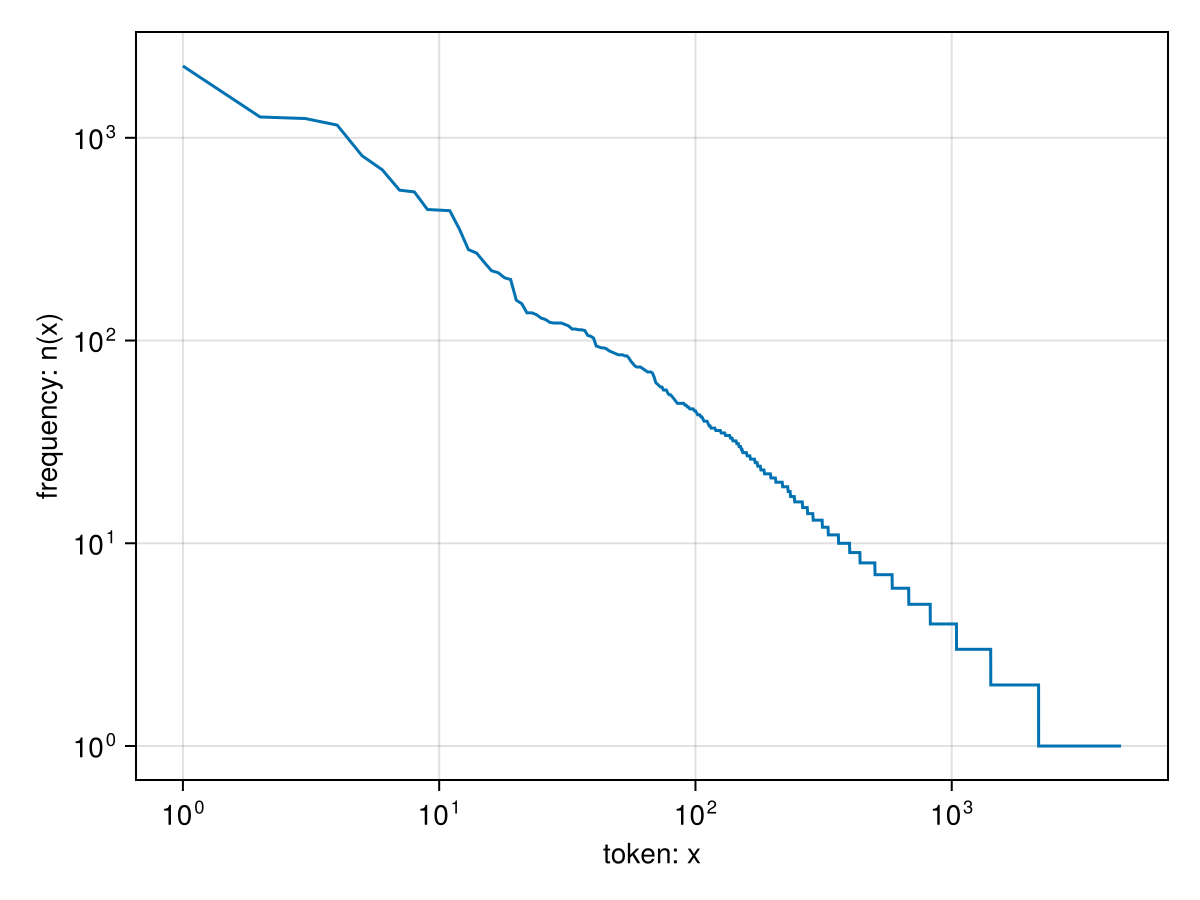

In [7]:
using CairoMakie

fg,ax = lines(last.(unigram); axis=(;xlabel = "token: x",ylabel = "frequency: n(x)", xscale = log10, yscale = log10))

This should already give us pause for thought if we want to model words by counting statistics. After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But what about the other word combinations, such as two consecutive words (bigrams), three consecutive words (trigrams), and beyond? Let’s see whether the bigram frequency behaves in the same manner as the single word (unigram) frequency.

In [8]:
bigram = sort([ngrams(sd, 2)...]; by = x -> x[2], rev=true)
bigram[1:10]

10-element Vector{Pair{AbstractString, Int64}}:
   "of the" => 309
   "in the" => 169
    "i had" => 130
    "i was" => 112
  "and the" => 109
 "the time" => 102
   "it was" => 99
   "to the" => 85
     "as i" => 78
     "of a" => 73

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book—“the time”. Furthermore, let’s see whether the trigram frequency behaves in the same manner.

In [9]:
trigram = sort([ngrams(sd, 3)...]; by = x -> x[2], rev=true)
trigram[1:10]

10-element Vector{Pair{AbstractString, Int64}}:
 "the time traveller" => 59
   "the time machine" => 30
    "the medical man" => 24
       "it seemed to" => 16
           "it was a" => 15
     "here and there" => 15
          "i did not" => 14
       "seemed to me" => 14
         "i began to" => 13
          "i saw the" => 13

Now, let’s visualize the token frequency among these three models: unigrams, bigrams, and trigrams.

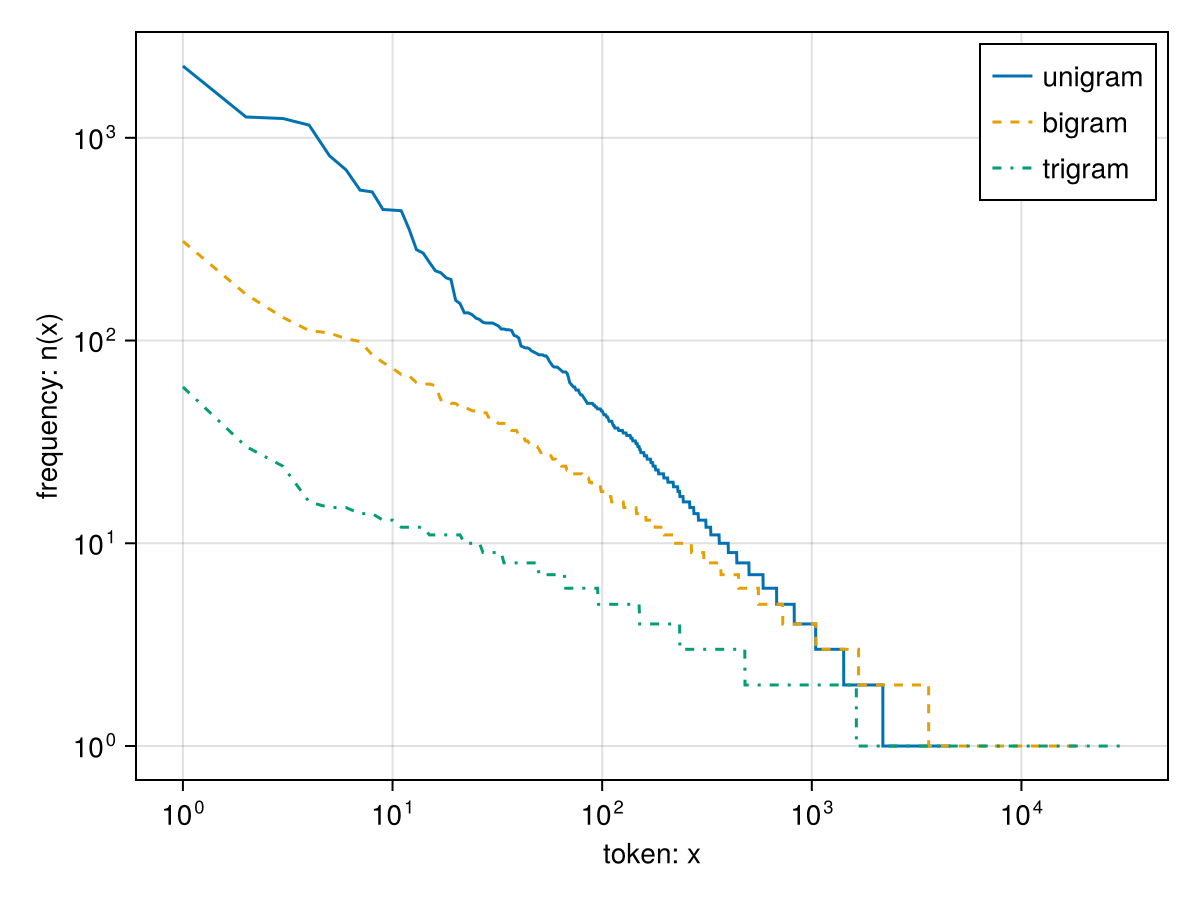

In [10]:
fg2,ax2 = lines(last.(unigram),label="unigram"; 
    axis=(;xlabel = "token: x", ylabel = "frequency: n(x)", xscale = log10, yscale = log10))
lines!(ax2,last.(bigram),label="bigram",linestyle=:dash)
lines!(ax2,last.(trigram),label="trigram",linestyle=:dashdot)
axislegend(position = :rt)
fg2

## Recurrent Neural Networks with Hidden States

To begin with, we define matrices X, W_xh, H, and W_hh, whose shapes are (3, 1), (1, 4), (3, 4), and (4, 4), respectively. Multiplying X by W_xh, and H by W_hh, and then adding these two products, we obtain a matrix of shape (3, 4).

In [13]:
X, W_xh = randn(3, 1), randn(1, 4)
H, W_hh = randn(3, 4), randn(4, 4)
X*W_xh+H*W_hh

3×4 Matrix{Float64}:
 -1.98493  2.83654   0.591937  -0.426544
 -2.20367  7.39051  -2.28091   -1.21806
  1.11862  1.13828  -2.7502     0.286596

Now we concatenate the matrices X and H along columns (axis 1), and the matrices W_xh and W_hh along rows (axis 0). These two concatenations result in matrices of shape (3, 5) and of shape (5, 4), respectively. Multiplying these two concatenated matrices, we obtain the same output matrix of shape (3, 4) as above.

In [14]:
cat(X,H; dims = 2)*cat(W_xh,W_hh;dims = 1)

3×4 Matrix{Float64}:
 -1.98493  2.83654   0.591937  -0.426544
 -2.20367  7.39051  -2.28091   -1.21806
  1.11862  1.13828  -2.7502     0.286596

## One-Hot Encoding

For example, if the vocabulary had five elements, then the one-hot vectors corresponding to indices 1 and 3 would be the following.

In [15]:
using OneHotArrays

onehotbatch([1,3],1:5)

5×2 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅
 ⋅  ⋅
 ⋅  1
 ⋅  ⋅
 ⋅  ⋅

（修改）
The minibatches that we sample at each iteration will take the shape (batch size, number of time steps). Once representing each input as a one-hot vector, we can think of each minibatch as a three-dimensional tensor, where the length along the third axis is given by the vocabulary size (len(vocab)). We often transpose the input so that we will obtain an output of shape (number of time steps, batch size, vocabulary size). This will allow us to loop more conveniently through the outermost dimension for updating hidden states of a minibatch, time step by time step.

In [60]:
model = Chain(RNN(27 => 32),Dense(32=>27))

num_steps = 10

a = [onehotbatch(to_indices(collect(i)),1:27) for i in  partition(str,num_steps,1)]
x = a[begin:end-1]
y = a[2:end]

loader = Flux.DataLoader((x,y),batchsize = 2)

for (x,y) in loader
    xs = eachslice(cat(x...;dims=3);dims=2)
    ys = eachslice(cat(y...;dims=3);dims=2)
    [model(xs[i]) for i in 1:10 ]
    break
end

# 时间步长度x字母特征
# x = partitions[:,1:5]
# # sequence_length x batch_size
# x


size(([model(xs[i]) for i = 1:10])[1]) = (27, 2)


## Defining the Model

We define the model using the RNN implemented by high-level APIs.

In [17]:
model = Chain(RNN(32 => 32),Dense(32=>32))

Chain(
  Recur(
    RNNCell(32 => 32, tanh),            # 2_112 parameters
  ),
  Dense(32 => 32),                      # 1_056 parameters
)         # Total: 6 trainable arrays, 3_168 parameters,
          # plus 1 non-trainable, 32 parameters, summarysize 12.742 KiB.

## Training and Predicting

Before training the model, let’s make a prediction with a model initialized with random weights. Given that we have not trained the network, it will generate nonsensical predictions.

In [18]:
# train_loader = time_machine_dataloader(32,1024)
for (x,y) in train_loader
    @show size(x)
    @show model(x)
    break
end
# batchsize * ( feature *  timestep)  
# =>
# timestep * ( feature * batchsize)

size(x) = (10, 2)


DimensionMismatch: DimensionMismatch: layer RNNCell(32 => 32, tanh) expects size(input, 1) == 32, but got 10×2 Matrix{Int64}